In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/dlpj/'
data_path = path + 'data/'
out_path = path + 'out0501/'
res_path = path + 'res/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score
from tqdm.autonotebook import tqdm, trange
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

In [0]:
torch.manual_seed(1)
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(os.getcwd())
print(os.listdir())

1
True
/content
['.config', 'drive', 'sample_data']


# Models

In [0]:
MASK_VALUE = -1e18

class SelfAttentionLSTM(nn.Module):
    
    def __init__(self, V, E, C, h=50, bidirectional=True, dropout=0.5):
        """
        
        V  | Vocab size
        E  | Embedding dimension
        C  | Number of classes
        h  | Hidden dimension
        ------------------------
        B  | Batch size
        L  | Max squence length
        H  | 2*h or h depending on bidirectional
        
        """
        super().__init__()
        self.embed = nn.Embedding(V, E)
        self.encoder = nn.LSTM(
            input_size=E,
            hidden_size=h,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.H = 2*h if bidirectional else h
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(in_features=self.H, out_features=C)
    
    def forward(self, x):
        mask = x != 0                               # B x L
        x = self.embed(x)                           # B x L x E
        x, _ = self.encoder(x)                      # B x L x H
        
        # self-attention
        attn_scores = x.bmm(x.transpose(-1, -2))    # (B x L x H) x (B x H x L) -> B x L x L
        mask = mask.unsqueeze(-1).expand_as(attn_scores)
        attn_scores = attn_scores.masked_fill(~mask, MASK_VALUE)
        attn = torch.softmax(attn_scores, dim=-1)   # B x L x L
        
        x = x + attn.bmm(x)                         # (B x L x L) x (B x L x H) -> B x L x H
        x = x.mean(dim=1)                           # B x H
        
        # output layer
        x = self.dropout(x)
        logits = self.linear(x)                     # B x H -> B x C
        
        return logits


class ICDCodeAttentionLSTM(nn.Module):
    
    def __init__(self, V, E, C, T, Tv, h=50, bidirectional=True, dropout=0.5):
        """
        
        V  | Vocab size
        E  | Embedding dimension
        C  | Number of classes
        h  | Hidden dimension
        ------------------------
        B  | Batch size
        L  | Max squence length
        H  | 2*h or h depending on bidirectional
        T  | Titles matrix of shape Tn x Tl
        Tn | No. of titles
        Tl | Max title squence length
        Tv | Titles vocab size
        
        """
        super().__init__()
        self.embed = nn.Embedding(V, E)
        self.encoder = nn.LSTM(
            input_size=E,
            hidden_size=h,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.embed_T = nn.Embedding(Tv, E)
        self.encoder_T = nn.LSTM(
            input_size=E,
            hidden_size=h,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.H = 2*h if bidirectional else h
        self.T = T
        self.C = C
        
        # output layers
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(in_features=self.H, out_features=C)
    
    def forward(self, x):
        B = x.shape[0]
        mask = x != 0                                   # B x L
        
        x = self.embed(x)                               # B x L x E
        x, _ = self.encoder(x)                          # B x L x H
        
        Te_mask = (self.T != 0).float()                 # Tn x Tl
        Te_mask = Te_mask.mean(dim=1) != 0              # Tl
        Te_mask = Te_mask.unsqueeze(0).expand(B, -1)    # B x Tl
        Te = self.embed_T(self.T)                       # Tn x Tl -> Tn x Tl x E
        Te, _ = self.encoder_T(Te)                      # Tn x Tl x H
        Te = Te.mean(dim=1)                             # Tn x H
        Te = Te.unsqueeze(0).expand(B, -1, -1)          # Tn x H -> 1 x Tn x H -> B x Tn x H
        x = torch.cat([x, Te], 1)                       # B x L' x H (where, L' = L + Tn)
        
        # self-attention
        attn_scores = x.bmm(x.transpose(-1, -2))        # (B x L' x H) x (B x H x L') -> B x L' x L'
        mask = torch.cat([mask, Te_mask], 1).unsqueeze(-1).expand_as(attn_scores)
        attn_scores = attn_scores.masked_fill(~mask, MASK_VALUE)
        attn = torch.softmax(attn_scores, dim=-1)       # B x L x L
        
        x = x + attn.bmm(x)                             # (B x L x L) x (B x L x H) -> B x L x H
        x = x.mean(dim=1)                               # B x H
        
        # output layer
        x = self.dropout(x)
        logits = self.linear(x)                         # B x H -> B x C
        
        return logits

# Train/Eval

In [0]:
def evaluate(dataloader, model, device, epoch):
    model.eval()
    probs = []
    logits = []
    preds = []
    labels = []
    ids = []
    avg_loss = 0.
    loss_fct = BCEWithLogitsLoss()
    
    def append(all_tensors, batch_tensor):
        if len(all_tensors) == 0:
            all_tensors.append(batch_tensor)
        else:
            all_tensors[0] = np.append(all_tensors[0], batch_tensor, axis=0)
        return all_tensors
    
    def detach(tensor, dtype=None):
        if dtype:
            return tensor.detach().cpu().numpy().astype(dtype)
        else:
            return tensor.detach().cpu().numpy()
    
    with torch.no_grad():  
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_inputs, b_labels, b_ids = batch

            b_logits = model(b_inputs)
            loss = loss_fct(b_logits, b_labels)
            avg_loss += loss.item()
            
            b_probs = torch.sigmoid(b_logits).detach().cpu()
            b_preds = (b_probs.numpy() >= 0.5).astype(int)
            b_logits = detach(b_logits, float)
            b_labels = detach(b_labels, int)
            b_ids = detach(b_ids, int)
            
            if len(probs) == 0:
                probs.append(b_probs)
            else:
                probs[0] = torch.cat((probs[0], b_probs))
            preds = append(preds, b_preds)
            logits = append(logits, b_logits)
            labels = append(labels, b_labels)
            ids = append(ids, b_ids)
    
    probs = probs[0]
    preds = preds[0]
    logits = logits[0]
    labels = labels[0]
    avg_loss /= len(dataloader)
    ids = ids[0]

    # score = f1_score(y_true=labels, y_pred=preds, average='micro')
    score = f1_score(y_true=labels, y_pred=preds, average='macro')
    
    hit15, hit8 = 0.0, 0.0
    top15_indices = torch.topk(probs, 15)[1]
    top8_indices = top15_indices[:, :8]
    for i in range(labels.shape[0]):
        hit15 += labels[i, :][top15_indices[i, :]].sum()
        hit8 += labels[i, :][top8_indices[i, :]].sum()
    hit15 /= labels.shape[0]
    hit15 /= 15
    hit8 /= labels.shape[0]
    hit8 /= 8

    print("Epoch{} eval - loss: {:.6f}, f1: {:.4f}, hit15: {:.6f}, hit8: {}".format(epoch, avg_loss, score, hit15, hit8))
    return score, (logits, preds, labels, ids, avg_loss, hit15, hit8)


def train(train_dataloader, dev_dataloader, model, 
          epochs, lr, device, grad_clip=None, 
          model_save_fname="model.pt",
          pos_weight=None):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    steps = 0
    best_fmicro = None
    loss_fct = BCEWithLogitsLoss(pos_weight=pos_weight)
    evals = []

    try:
        for epoch_no in trange(epochs, desc="Epoch"):
            model.train()
            tr_loss = 0.0
            nb_tr_examples, nb_tr_steps = 0, 0

            for step, batch in enumerate(train_dataloader):
                batch = tuple(t.to(device) for t in batch)
                inputs, labels, ids = batch
                
                logits = model(inputs)
                loss = loss_fct(logits, labels)
                loss.backward()
                
                tr_loss += loss.item()
                nb_tr_examples += inputs.size(0)
                nb_tr_steps += 1
                
                if grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                
                optimizer.step()
                optimizer.zero_grad()
                steps += 1 
            
            score, eval_data = evaluate(dev_dataloader, model, device, epoch_no+1)
            
            if not best_fmicro or score > best_fmicro:
                # print("best_fmicro @{}: {}".format(epoch_no, score))
                torch.save(model.state_dict(), model_save_fname)
                best_fmicro = score
            
            evals.append((epoch_no, score, eval_data, tr_loss / len(train_dataloader)))
    
    except KeyboardInterrupt:
        print('-' * 89)
        print('Exiting from training early')
    
    return evals

# Evaluation

In [0]:
def final_eval(ids_file, anns_file, dev_file, out_file):
	ids = load_ids_dev(ids_file)
	anns = load_anns_dev(anns_file, ids)
	preds = load_preds(dev_file,ids)
	# evaluate and print errors
	tps = 0.0
	fps = 0.0
	fns = 0.0
	out_file = open(out_file, "w")
	for id in ids:
		anns_id = anns[id]
		if id in preds:
			preds_id = preds[id]
		else:
			preds_id = []
		for pred in preds_id:
			if pred in anns_id:
				tps += 1
				out_file.write('TP\t'+id+'\t'+pred+'\n')
			else:
				fps += 1
				out_file.write('FP\t'+id+'\t'+pred+'\n')
		for ann in anns_id:
			if ann not in preds_id:
				fns += 1
				out_file.write('FN\t'+id+'\t'+ann+'\n')
	out_file.write('TPs='+str(tps)+'\n')
	print('TPs='+str(tps))
	out_file.write('FPs='+str(fps)+'\n')
	print('FPs='+str(fps))
	out_file.write('FNs='+str(fns)+'\n')
	print('FNs='+str(fns))
	precision = tps/(tps+fps)
	out_file.write('precision='+str(precision)+'\n')
	print('precision='+str(precision))
	recall = tps/(tps+fns)
	out_file.write('recall='+str(recall)+'\n')
	print('recall='+str(recall))
	fscore = 2*precision*recall/(precision+recall)
	out_file.write('fscore='+str(fscore)+'\n')
	print('fscore='+str(fscore))
	
def load_preds(dev_file,ids):
	preds = {}
	f = open(dev_file, "r")
	for line in f:
		if '\t' in line.strip(): 
			id,str_preds = line.strip().split('\t')
			if id in ids:
				if str_preds is not None:
					preds[id] = str_preds.split('|')
				else:
					preds[id] = []
		else:
			id = line.strip()
			preds[id] = []
	print('Number of documents with predictions:',len(preds))
	return preds	

def load_anns_dev(anns_file,ids):
	anns = {}
	f = open(anns_file, "r")
	for line in f:
		'''changed'''
		id_str_anns = line.strip().split('\t')
		if len(id_str_anns) == 1: continue
		id,str_anns = id_str_anns
		'''changed'''
		if id in ids:
			if str_anns is not None:
				anns[id] = str_anns.split('|')
			else:
				anns[id] = []
	# add dev doc without annotations
	for id in ids:
		if id not in anns.keys():
			anns[id] = []
	return anns

def load_ids_dev(ids_file):
	f = open(ids_file, "r")
	ids = [line.strip() for line in f ]
	print('Number of dev documents:',len(ids))
	return ids


# Utils

In [0]:
def batched_data(*tensors, batch_size=64):
    data = TensorDataset(*tensors)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

def read_ids(ids_file):
    ids = set()
    with open(ids_file, "r") as rf:
        for line in rf:
            line = line.strip()
            if line:
                if line == "id": # line 242 in train ids
                    continue
                ids.add(int(line))
    return ids

def generate_preds_file(preds, preds_ids, mlb_file, testids_file, preds_file): 
    with open(mlb_file, "rb") as rf:
        mlb = pkl.load(rf)
    
    all_ids_dev = list(read_ids(testids_file))
    preds = [mlb.classes_[preds[i, :].astype(bool)].tolist() for i in range(preds.shape[0])]
    id2preds = {val:preds[i] for i, val in enumerate(preds_ids)}
    preds = [id2preds[val] if val in id2preds else [] for i, val in enumerate(all_ids_dev)]
    
    with open(preds_file, "w") as wf:
        for idx, doc_id in enumerate(all_ids_dev):
            line = str(doc_id) + "\t" + "|".join(preds[idx]) + "\n"
            wf.write(line)
    
    # return preds

def load(fname):
    with open(fname, "rb") as rf:
        data = pkl.load(rf)
    return data

# Main

In [0]:
def main(model_name, date, device,
         batch_size=64, embed_dim=300, hidden_dim=300, 
         epochs=1, lr=0.001, bidirectional=True,
         embed_file=None, embed_T_file=None,
         model_file=None
         ):
    
    model_type = model_name.split('_')[0]
    if model_type not in ("slstm", "clstm"):
        raise ValueError
    
    if embed_file:
        embed_dim = 768
    
    if model_type == "clstm":
        T, titles_word2index = load(T_file), load(titles_word2index_file)
    
    word2index = load(word2index_file)

    train_data = load(train_data_file)
    dev_data = load(dev_data_file)
    test_data = load(test_data_file)
    Xtrain, ytrain, ids_train = train_data
    Xdev, ydev, ids_dev = dev_data
    Xtest, ytest, ids_test = test_data
    vocab_size = len(word2index)
    num_classes = ytrain[0].shape[0]

    # get_pos_weight
    total_num = ytrain.size(0)
    pos_cnt = ytrain.sum(dim=0)
    neg_cnt = total_num - pos_cnt
    tmp = neg_cnt / pos_cnt
    pos_weight = torch.tensor(tmp).cuda()
    
    train_dataloader = batched_data(Xtrain, ytrain, ids_train, batch_size=batch_size)
    dev_dataloader = batched_data(Xdev, ydev, ids_dev, batch_size=batch_size)
    test_dataloader = batched_data(Xtest, ytest, ids_test, batch_size=batch_size)
    
    if embed_file:
        embed_matrix = load(embed_file)
        if model_type == "clstm":
            embed_matrix_T = load(embed_T_file)
    else:
        embed_matrix = None
        embed_matrix_T = None
    
    if model_type == "slstm":
        model = SelfAttentionLSTM(
            vocab_size, embed_dim, num_classes, 
            h=hidden_dim, bidirectional=bidirectional
        )
    else:
        model = ICDCodeAttentionLSTM(
            vocab_size, embed_dim, num_classes, T.cuda(),
            Tv=len(titles_word2index), h=hidden_dim, 
            bidirectional=bidirectional
        )
    
    if model_file:
        model.load_state_dict(torch.load(model_file))
        print('Model: loaded pretrained model.')
    elif embed_file:
        model.embed.weight.data.copy_(torch.from_numpy(embed_matrix))
        if model_type == "clstm":
            model.embed_T.weight.data.copy_(torch.from_numpy(embed_matrix_T))
        print('Model: init new model w/ embed files.')
    
    model = model.to(device)
    print(model_name)
    print(model)
    
    model_save_fname = res_path + "model_{}_{}.pt".format(model_name, date)
    epoch_evals = train(
        train_dataloader, dev_dataloader, model, epochs, lr, 
        device=device, grad_clip=14.0, model_save_fname=model_save_fname,
        pos_weight = pos_weight
    )
    
    _, (_, preds, _, ids, _, hit15, hit8) = evaluate(test_dataloader, model, device, 0)
    print('Test result (complement w/ eval output) - hit15: {:.6f}, hit8: {}'.format(hit15, hit8))

    return model, model_save_fname, preds, ids, epoch_evals

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
T_file = out_path + 'title2tensor_256_0501.pkl'
titles_word2index_file = out_path + 'title2index_256_0501.pkl'
train_data_file = out_path + 'train_tensor_256_0501.pkl'
dev_data_file = out_path + 'dev_tensor_256_0501.pkl'
test_data_file = out_path + 'test_tensor_256_0501.pkl'
word2index_file = out_path + 'word2index_256_0501.pkl'

In [0]:
model_name = "slstm"
date = '0509'
model, model_save_fname, test_preds, preds_ids, epoch_evals = main(
    epochs=10,
    lr = 0.001,
    model_name=model_name,
    date=date,
    device=device,
    embed_file=data_path + 'embedding_word_0501.pkl',
    # embed_T_file=data_path + 'embedding_title_0501.pkl'
    # model_file=res_path + 'model_clstm_pos_weight_0504.pt'
)

Model: init new model w/ embed files.
slstm
SelfAttentionLSTM(
  (embed): Embedding(10000, 768)
  (encoder): LSTM(768, 300, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=600, out_features=300, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch1 eval - loss: 0.598679, f1: 0.0919, hit15: 0.124000, hit8: 0.16525
Epoch2 eval - loss: 0.615719, f1: 0.0952, hit15: 0.125800, hit8: 0.14925
Epoch3 eval - loss: 0.568666, f1: 0.1029, hit15: 0.131533, hit8: 0.169375
Epoch4 eval - loss: 0.535074, f1: 0.1063, hit15: 0.134600, hit8: 0.1755
Epoch5 eval - loss: 0.743419, f1: 0.0968, hit15: 0.129133, hit8: 0.158875
Epoch6 eval - loss: 0.502467, f1: 0.1111, hit15: 0.149200, hit8: 0.18825
Epoch7 eval - loss: 0.467783, f1: 0.1139, hit15: 0.147067, hit8: 0.18025
Epoch8 eval - loss: 0.471189, f1: 0.1137, hit15: 0.152533, hit8: 0.192125
Epoch9 eval - loss: 0.496297, f1: 0.1102, hit15: 0.141467, hit8: 0.175625
Epoch10 eval - loss: 0.446421, f1: 0.1142, hit15: 0.144533, hit8: 0.18125

Epoch0 eval - loss: 0.432743, f1: 0.1128, hit15: 0.154405, hit8: 0.19479625550660792
Test result (complement w/ eval output) - hit15: 0.154405, hit8: 0.19479625550660792


In [0]:
# torch.save(model.state_dict(), model_save_fname)
generate_preds_file(
    test_preds, preds_ids, 
    mlb_file=out_path + 'mlb_256_0501.pkl', 
    testids_file=out_path + 'test_ids_256_0501.txt', 
    preds_file=res_path + "preds_{}_{}.txt".format(model_name, date)
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
print("eval results with challenge script:")
final_eval(
    out_path + 'test_ids_256_0501.txt',
    out_path + 'test_anns_256_0501.txt', 
    res_path + "preds_{}_{}.txt".format(model_name, date),
    res_path + "eval_{}_{}.txt".format(model_name, date)
)

eval results with challenge script:
Number of dev documents: 908
Number of documents with predictions: 908
TPs=5891.0
FPs=69351.0
FNs=2175.0
precision=0.07829403790436193
recall=0.7303496156707165
fscore=0.14142699380611706


Text(0.5, 0.98, 'clstm')

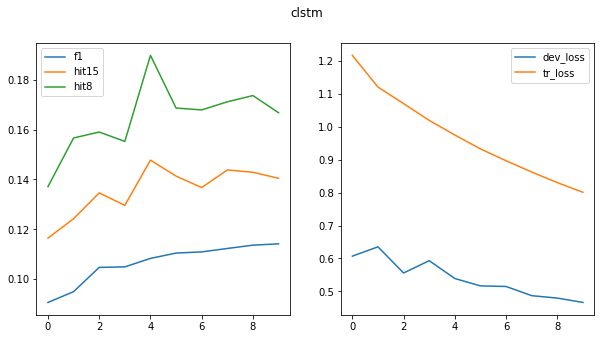

In [0]:
import matplotlib.pyplot as plt
epoch_no = [e[0] for e in epoch_evals]
score = [e[1] for e in epoch_evals]
hit15 = [e[2][5] for e in epoch_evals]
hit8 = [e[2][6] for e in epoch_evals]
dev_loss = [e[2][4] for e in epoch_evals]
train_loss = [e[3] for e in epoch_evals]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(score, label='f1')
ax1.plot(hit15, label='hit15')
ax1.plot(hit8, label='hit8')
ax2.plot(dev_loss, label='dev_loss')
ax2.plot(train_loss, label='tr_loss')
ax1.legend()
ax2.legend()
plt.suptitle(model_name)

# score, (logits, preds, labels, ids, avg_loss, hit15, hit8)

# TODO 0501
- add load pretrained model weights


# Result
- clstm: epochs=50, lr=0.001, embed=True, embed_T=True
```
TPs=1512.0
FPs=1840.0
FNs=15724.0
precision=0.4510739856801909
recall=0.0877233696913437
fscore=0.14688167864775598
```
- anns file dedup, clstm: epochs=50, lr=0.001, embed=True, embed_T=True
```
TPs=1487.0
FPs=1799.0
FNs=7887.0
precision=0.45252586731588557
recall=0.15863025389374866
fscore=0.23491311216429697
```
- clstm from scratch (no pretrain): epochs=50, lr=0.001
```
TPs=1526.0
FPs=1995.0
FNs=7848.0
precision=0.43339960238568587
recall=0.16279069767441862
fscore=0.2366808840635905
```
- clstm from scratch: lr=0.1, lol, turbulent curves...
```
TPs=912.0
FPs=893.0
FNs=8462.0
precision=0.5052631578947369
recall=0.09729037764028163
fscore=0.16316307362018073
```
- clstm w/ correct data 0501
```
TPs=1407.0
FPs=1662.0
FNs=6659.0
precision=0.458455522971652
recall=0.17443590379370197
fscore=0.2527166591827571
```
- clstm 300ep pos weight
```
TPs=3075.0
FPs=10727.0
FNs=4991.0
precision=0.2227937980002898
recall=0.3812298537069179
fscore=0.28123285165538686
```
- clstm 20ep pos weight high level codes 0506
```
TPs=1372.0
FPs=709.0
FNs=642.0
precision=0.6592984142239308
recall=0.6812313803376365
fscore=0.67008547008547
```